In [1]:
%matplotlib notebook
import matplotlib.pyplot as plt
from colicoords.cnn.unet import get_unet_256
from colicoords.cnn.preprocess import DefaultImgSequence, resize_stack
from colicoords import iter_subplots
import tensorflow as tf
from tensorflow.keras.callbacks import ModelCheckpoint
import tifffile

Using TensorFlow backend.


This example features the segmentation of brightfield images using convolutional neural networks. The `cnn` module offers functions to generate neural networks (`models`) which can be trained to segment images. The architecture of the model is an implementation of the U-Net [1] architecture. This network extracts features from images through a series of convolutional layers, after which these features are used to form the final segmented image through a series of upsampling layers. 

To get started with segmentation, a training data set is needed consisting of already segmented images. In our experience we found that around 400 images is sufficient, although fewer images may also give a satisfactory result. A simple tool to manually segment images can be found in the `gui` module of `ColiCoords`. (Example usage script can be found __[here](https://github.com/Jhsmit/ColiCoords-Paper/blob/master/figures/Figure_6/gui_annotate.py)__)

We have used a midrange graphics card (Nvidia GeForce GTX 1060 6GB) for training the network. Due to memory limitations the images where scaled down from 512x512 to 256x256. This might not be nessecary if more GPU memory is available.

[1] Olaf Ronneberger, Philipp Fischer, Thomas Brox, U-Net: Convolutional Networks for Biomedical Image Segmentation __[arXiv:1505.04597](https://arxiv.org/abs/1505.04597)__

Binary images are loaded and resize to 256x256 to save video memory:

In [2]:
# Modify these lines to import the training data brightfield and binary
brightfield = tifffile.imread('data/02/brightfield_stack.tif')
binary = tifffile.imread(r'data/02/binary_stack.tif')
brightfield.shape, binary.shape

((20, 512, 512), (20, 512, 512))

In [3]:
brightfield_resized = resize_stack(brightfield, 0.5)
binary_resized = resize_stack((binary > 0).astype(int), 0.5, img_type= 'binary')

<IPython.core.display.Javascript object>


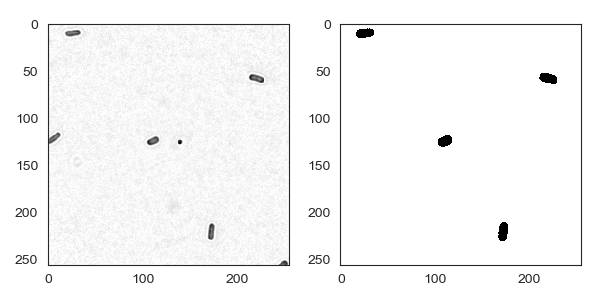

In [6]:
fig, axes = iter_subplots(1, 2, figsize=(6, 3))
axes[0].iter_imshow(brightfield_resized, cmap='gray')
axes[1].iter_imshow(binary_resized, cmap='gray_r')
fig.display()
plt.tight_layout()

The brightfield and binary data are used to initalize an `DefaultImgSequence` object. This is a subclass of `Sequence` from `keras` which acts as a `generator` to generate more images from the input training data. The amount of data is increased 8-fold though a series of rotations and reflections, as they also are valid training images. This is done to create more training data to prevent over-fitting. 

The `DefaultImgSequence` object also normalized the images in real-time though tanh (Hampel) normalization.

Over-fitting is a frequently occuring problem in training neural networks. If the network is trained on a too low number of images, it is possible for the network to 'memorize' images instead of recognizing patterns. Therefore, the training data is split into two sets; training (in-sample) and validation (out-of-sample) data. After each epoch of training the model is checked against the validation data. During training, an increased validation loss while in-sample loss is decreasing could be due to over-fitting.

In [7]:
isq = DefaultImgSequence(brightfield_resized, binary_resized)
vsq, tsq = isq.val_split(1/8., random=True)

Warning, index out of bounds, set to last element


The model is initialized by calling `get_unet_256`. The input shape is (width, height, channels). Other shapes are available in `cnn.unet` and custom shapes can be supplied as keyword argument.

In [7]:
model = get_unet_256(input_shape=(256, 256, 1))

Pretrained model weights will be made available shortly and can be loaded as:

In [8]:
model.load_weights('PATH TO MODEL WEIGHTS.h5')

A checkpoint is created to save the model's weights every time the validation loss decreases.

In [11]:
checkpoint = ModelCheckpoint('model_example', monitor='val_loss', save_weights_only=True, save_best_only=True, verbose=1, mode='min')

The last step is to start training the model! Depending on the weights used to initialize the model, the number of input images and the hardware used this can take anywhere from minutes to hours. It is recommended to start out with a small number of epochs (full iteration of all data) to see how the validation loss (val_loss) progresses.

In [15]:
model.fit_generator(train_sq, steps_per_epoch=len(train_sq), epochs=5 validation_data=val_sq,callbacks=[checkpoint])

Epoch 1/1
208/240 [=========================>....] - ETA: 34:33 - loss: 0.1466 - acc: 0.95 - ETA: 18:12 - loss: 0.1779 - acc: 0.94 - ETA: 12:45 - loss: 0.1378 - acc: 0.95 - ETA: 10:01 - loss: 0.1141 - acc: 0.96 - ETA: 8:22 - loss: 0.0971 - acc: 0.9727 - ETA: 7:16 - loss: 0.2085 - acc: 0.960 - ETA: 6:29 - loss: 0.3122 - acc: 0.951 - ETA: 5:54 - loss: 0.2795 - acc: 0.956 - ETA: 5:26 - loss: 0.2532 - acc: 0.960 - ETA: 5:04 - loss: 0.2307 - acc: 0.963 - ETA: 4:45 - loss: 0.2132 - acc: 0.966 - ETA: 4:30 - loss: 0.2004 - acc: 0.968 - ETA: 4:17 - loss: 0.1889 - acc: 0.970 - ETA: 4:06 - loss: 0.1798 - acc: 0.971 - ETA: 3:56 - loss: 0.1958 - acc: 0.967 - ETA: 3:47 - loss: 0.2316 - acc: 0.961 - ETA: 3:40 - loss: 0.2205 - acc: 0.963 - ETA: 3:33 - loss: 0.2117 - acc: 0.965 - ETA: 3:26 - loss: 0.2055 - acc: 0.965 - ETA: 3:21 - loss: 0.1973 - acc: 0.966 - ETA: 3:16 - loss: 0.1892 - acc: 0.967 - ETA: 3:11 - loss: 0.1834 - acc: 0.968 - ETA: 3:07 - loss: 0.1776 - acc: 0.969 - ETA: 3:02 - loss: 0.1727 -